In [15]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_one_warehouse_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']
    if 'master' in reference_row:
        out_row['master'] = reference_row['master']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green  
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Circle
    1024: "v",         # Down triangle
    8192: "s",         # Square
}

linestyle_scheme = {
    "Vanilla": "-",  # Dashed
    "GNN": "--",         # Solid
    #"GNN_bottleneck": "-.",  # Dotted
}
# Define paths for each architecture
# Define architectures with their path patterns
architectures = {
    "Vanilla": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_warehouse',
    "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    #"GNN_bottleneck": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_bottleneck',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define number of stores and sample sizes
n_stores = [3, 5, 10, 20, 30, 50]
sample_sizes = [128, 1024, 8192]

dfs = []

# Create dataframes for each architecture, passing n_stores and sample_sizes as arrays
for arch_name, path_fn in architectures.items():
    # Use the first n_store just to generate the path (assuming path does not depend on n_store)
    path = path_fn(n_stores[0])
    df = results_interpretor.make_table({1: path},
        {
            'train_dev_sample_and_batch_size': sample_sizes,
            'store_underage_cost': [9],
            'store_lead_time': [[2, 6]],
            'samples': [1],
            'n_stores': n_stores
        },
        default_condition_setter, custom_data_filler,
        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
        test_loss_limit=25
    )
    if df.empty:
        continue

    df.insert(2, 'Architecture Class', arch_name)
    df.insert(1, 'hyperparam_name', arch_name)
    dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

import numpy as np

test_loss_column = 'Test Loss'
test_loss_filename = 'one_warehouse_lost_demand_5000_test_loss.txt'

test_losses = []
for _, row in df.iterrows():
    test_loss_path = str(row['path']) +"/"+ test_loss_filename
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df[test_loss_column] = test_losses

[autoreload of typing_extensions failed: Traceback (most recent call last):
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/lib/python3.10/site-packages/typing_extensions.py", line 844, in <module>
    class SupportsAbs(P

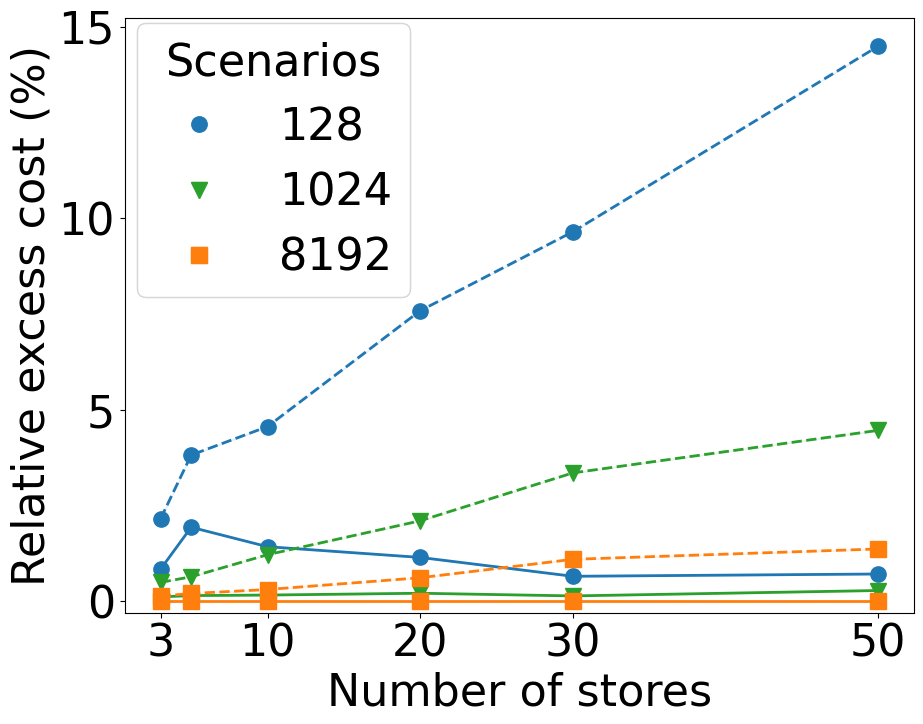

In [ ]:
# Calculate gap percentage using best performing loss for each n_stores
stats_by_arch_sample_and_stores = {}

# Marker, color, and linestyle schemes
sample_sizes_ordered = [128, 1024, 8192]
marker_scheme = {128: 'o', 1024: 'v', 8192: 's'}
color_scheme = {128: "#1f77b4", 1024: "#2ca02c", 8192: "#ff7f0e"}
linestyle_scheme = {"GNN": "-", "Vanilla": "--"}

for n_store in n_stores:
    store_data = df[df['n_stores'] == n_store].copy()
    if store_data.empty:
        continue
    best_test_loss = store_data['Test Loss'].min()
    store_data.loc[:, 'Gap %'] = ((store_data['Test Loss'] - best_test_loss) / best_test_loss) * 100

    for arch in store_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_stores:
                stats_by_arch_sample_and_stores[key] = []

            sample_data = store_data[
                (store_data['train_dev_sample_and_batch_size'] == sample_size) &
                (store_data['Architecture Class'] == arch)
            ]
            if not sample_data.empty:
                gaps = sample_data['Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_arch_sample_and_stores[key].append({
                    'n_stores': n_store,
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })

FONTSIZE = 32
fig = plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': FONTSIZE})

linewidth = 2
markersize = 11

# Plot lines, arch order: GNN, Vanilla NN; sample order: 128, 1024, 8192
arch_order = ["GNN", "Vanilla"]
for arch in arch_order:
    for sample_size in sample_sizes_ordered:
        key = (arch, sample_size)
        stats = stats_by_arch_sample_and_stores.get(key, [])
        stats_df = pd.DataFrame(stats)
        if not stats_df.empty:
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_gap_array = stats_df['mean_gap'].to_numpy()
            ci_lower_array = stats_df['ci_lower'].to_numpy()
            ci_upper_array = stats_df['ci_upper'].to_numpy()
            plt.plot(
                n_stores_array, mean_gap_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=markersize,
                linewidth=linewidth,
                label=f"{arch} {sample_size}"
            )
            plt.fill_between(
                n_stores_array,
                ci_lower_array,
                ci_upper_array,
                color=color_scheme[sample_size],
                alpha=0.1
            )

# Legend handles for architectures (GNN above Vanilla)
arch_lines = [
    plt.Line2D(
        [0], [0],
        color='black',
        linestyle=linestyle_scheme[arch],
        linewidth=linewidth,
        label=arch
    )
    for arch in arch_order
]

# Legend handles for sample sizes (from low to high)
sample_patches = [
    plt.Line2D(
        [0], [0],
        color=color_scheme[size],
        marker=marker_scheme[size],
        linestyle='none',
        label=f'{size}',
        markersize=markersize
    )
    for size in sample_sizes_ordered
]

plt.xlabel('Number of stores', fontsize=FONTSIZE)
plt.ylabel('Relative excess cost (%)', fontsize=FONTSIZE)
plt.ylim(bottom=-0.3)

# Set custom x-ticks
xtick_values = [3, 10, 20, 30, 50]
plt.xticks(xtick_values, [str(x) for x in xtick_values], fontsize=FONTSIZE)

plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()

# Right legend for architectures (GNN above Vanilla)
# legend1 = plt.legend(
#     handles=arch_lines,
#     bbox_to_anchor=(0.78, 1),
#     loc='upper right',
#     fontsize=FONTSIZE,
#     borderaxespad=0.1,
#     framealpha=0.6
# )
# plt.gca().add_artist(legend1)

# Left legend for sample sizes (low to high), with title
legend2 = plt.legend(
    handles=sample_patches,
    title='Scenarios',
    bbox_to_anchor=(0.01, 1),
    loc='upper left',
    fontsize=FONTSIZE,
    borderaxespad=0.1,
    framealpha=0.6
)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.savefig("/user/ml4723/Prj/NIC/Plots/sample_efficiency_OWMS.pdf", bbox_inches='tight')
plt.show()

In [12]:
import numpy as np

# Prepare the new DataFrame
def get_val(row, col):
    return row[col] if col in row and pd.notnull(row[col]) else "-"

def get_loss(row, col):
    val = row[col] if col in row and pd.notnull(row[col]) else "-"
    if val == "-":
        return val
    return round(val, 2)

def get_master(row):
    return int(row['master']) if 'master' in row and pd.notnull(row['master']) else "-"

def get_learning_rate(row):
    return row['Learning Rate'] if 'Learning Rate' in row and pd.notnull(row['Learning Rate']) else "-"

def get_arch(row):
    if row['Architecture Class'] == "Vanilla NN":
        return "Vanilla"
    return row['Architecture Class']

# Build the table
table_rows = []
for _, row in df.iterrows():
    table_rows.append({
        "Number of stores": int(row['n_stores']) if 'n_stores' in row and pd.notnull(row['n_stores']) else "-",
        "Training scenarios (#)": int(row['train_dev_sample_and_batch_size']) if 'train_dev_sample_and_batch_size' in row and pd.notnull(row['train_dev_sample_and_batch_size']) else "-",
        "Architecture Class": get_arch(row),
        "Learning rate": get_learning_rate(row),
        "Units per layer (#)": get_master(row),
        "Train loss": get_loss(row, 'Train Loss'),
        "Dev loss": get_loss(row, 'Dev Loss'),
        "Test loss": row['Test Loss'] if 'Test Loss' in row and pd.notnull(row['Test Loss']) else "-",
        "Relative Excess Test Loss (%)": "-",  # to be filled later
    })

df_table = pd.DataFrame(table_rows)

# Compute Relative Excess Test Loss (%)
for n_stores in df_table["Number of stores"].unique():
    mask = df_table["Number of stores"] == n_stores
    test_losses = df_table.loc[mask, "Test loss"]
    # Only consider numeric test losses
    numeric_losses = pd.to_numeric(test_losses, errors='coerce')
    if numeric_losses.notnull().any():
        min_loss = numeric_losses.min()
        for idx in df_table[mask].index:
            val = df_table.at[idx, "Test loss"]
            try:
                val_float = float(val)
                rel_gap = 100 * (val_float - min_loss) / min_loss if min_loss != 0 else 0
                df_table.at[idx, "Relative Excess Test Loss (%)"] = round(rel_gap, 2)
            except:
                df_table.at[idx, "Relative Excess Test Loss (%)"] = "-"
    else:
        df_table.loc[mask, "Relative Excess Test Loss (%)"] = "-"

# Round losses and gaps
for col in ["Train loss", "Dev loss", "Test loss", "Relative Excess Test Loss (%)"]:
    df_table[col] = df_table[col].apply(lambda x: round(float(x), 2) if isinstance(x, (float, int, np.floating, np.integer)) and not pd.isnull(x) else x)

# Find and bold the minimum test loss for each number of stores (before rounding)
def bold_min_test_loss(group):
    # Only consider numeric test losses
    numeric_losses = pd.to_numeric(group["Test loss"], errors='coerce')
    if numeric_losses.notnull().any():
        min_idx = numeric_losses.idxmin()
        val = group.loc[min_idx, "Test loss"]
        # Use the original value before rounding for comparison, but display rounded
        group.loc[min_idx, "Test loss"] = f"\\textbf{{{round(float(val), 2)}}}"
    return group

df_table = df_table.groupby("Number of stores", group_keys=False).apply(bold_min_test_loss)

# Sort: Number of stores, Training scenarios (#), Architecture Class (GNN first, then Vanilla)
def arch_sort_key(arch):
    return 0 if arch == "GNN" else 1

df_table = df_table.sort_values(
    by=["Number of stores", "Training scenarios (#)", "Architecture Class"],
    key=lambda col: col.map(arch_sort_key) if col.name == "Architecture Class" else col
).reset_index(drop=True)

print(df_table.to_string(index=False))

 Number of stores  Training scenarios (#) Architecture Class  Learning rate Units per layer (#)  Train loss  Dev loss     Test loss  Relative Excess Test Loss (%)
                3                     128                GNN         0.0100                   -        5.43      5.63          5.64                           0.84
                3                     128            Vanilla         0.0001                 512        5.36      5.70          5.72                           2.16
                3                    1024                GNN         0.0001                   -        5.59      5.62  \textbf{5.6}                           0.12
                3                    1024            Vanilla         0.0010                 128        5.59      5.64          5.63                           0.49
                3                    8192                GNN         0.0001                   -        5.59      5.59           5.6                           0.00
                3     

/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_36066/2714831602.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{5.6}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group.loc[min_idx, "Test loss"] = f"\\textbf{{{round(float(val), 2)}}}"
/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_36066/2714831602.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{5.26}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group.loc[min_idx, "Test loss"] = f"\\textbf{{{round(float(val), 2)}}}"
/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_36066/2714831602.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{5

In [21]:
mode = "test"
setting_names = ['one_warehouse_lost_demand_5000']

models = []
import pandas as pd

for _, row in df.iterrows():
    if row['Architecture Class'] == 'GNN':
        progress_path = str(row['path']) + '/progress.csv'
        progress_df = pd.read_csv(progress_path)
        min_idx = progress_df['dev_loss'].idxmin()
        model_name = f"model_{min_idx * 10}.pt"
        models.append(str(row['path']) + '/' + model_name)
    else:
        models.append(str(row['path']) + '/model.pt')

gpus = [0, 1, 2, 4, 5]

def run_main_run(model_path, setting_name, gpu_idx):
    try:
        # Extract hyperparam name from model path
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode, # test or test_on_dev
            setting_name,
            hyperparam_name,
            str(model_path),
            str(gpus[gpu_idx])
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    gpu_idx = 0
    for setting_name in setting_names:
        for path in models:
            while len(futures) >= 4*len(gpus):
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, path, setting_name, gpu_idx))
            gpu_idx = (gpu_idx + 1) % len(gpus)
    concurrent.futures.wait(futures)


Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_one_warehouse_n_stores/GNN_selfloop/run_2025-05-15_23-35-54/run_df11a_00105_105_config=one_warehouse_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_st_2025-05-15_23-35-55/model_170.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_one_warehouse_n_stores/GNN_selfloop/run_2025-05-15_23-35-54/run_df11a_00053_53_config=one_warehouse_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-15_23-35-55/model_5650.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_one_warehouse_n_stores/GNN_selfloop/run_2025-05-15_23-35-54/run_df11a_00017_17_config=one_warehouse_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-15_23-35-55/model_2600.pt
Running main_run.py for pa